
maxhöjd: 1.110m efter 1.514s
tid till y=0: 2.666s
maxfart: 2.191m/s efter 9.196s
sista fart: -1.788m/s




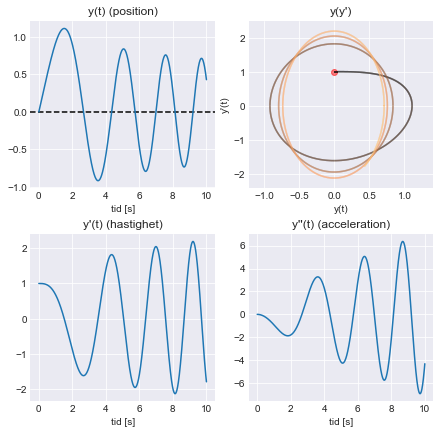

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from euler_cromer import simulate
from utils.colorline import colorline

def f(y, y_dot, t):
    return -y*t

initial = [0, 1]
from_time, to_time, dt = 0, 10, 0.001
res = simulate(f, initial, dt, from_time, to_time, plot=True)
t, y = res['t'], res['y']
sol = (t**3)/3 + t - 1/3

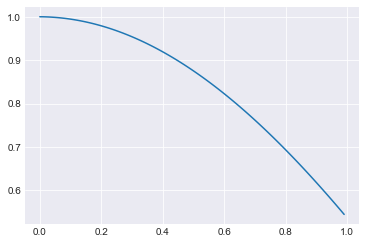

In [8]:
fig, ax = plt.subplots()
ax.set_xmargin(0.05)
ax.set_ymargin(0.05)
ax.plot(t, y)